In [1]:
# STAT6011 Assignment 2
# Author: LAM Hin Tai
# UID: 2004062587

import pandas as pd
import numpy as np
from scipy.stats import invgamma
import matplotlib.pyplot as plt
import os

# Make it reproducible
np.random.seed(299)

In [2]:
dataFilePath = "P:\\__personal\\MStat\\_S4 6011\\A2"
dataFile = os.path.join(dataFilePath, "beer_data.txt")
df = pd.read_csv(dataFile, sep="\t")

In [3]:
# ANOVA - i = 1-6; j = 1-8, (i.e. n_i = 8 for all i)
I = max(df["Beer"])
J = max(df["Obs"])
n = np.array([J] * I)
N = np.sum(n)

# y - 6x8
y = np.array(df["Sodium"]).reshape(I, J)
yMean = np.mean(y, 1)   # vector of y_i's means
yGrandMean = np.mean(yMean)

In [5]:
# Q8b - One-way ANOVA with Gibbs Sampler
nIter = 100000
nBurnin = 10000

# Hyperparameters
a = 0.1
b = 0.1

In [6]:
# Gibbs sampler update functions for mu, alpha_i, sigmaSq, tauSq
def updateMu(currAlpha, currSigmaSq):
    muMean = yGrandMean - np.sum(np.multiply(n, currAlpha))/N
    muVar = currSigmaSq/N
    mu = np.random.normal(muMean, np.sqrt(muVar))
    return mu

def updateAlpha(currMu, currSigmaSq, currTauSq):
    alphaMean = currTauSq*(yMean - currMu) / (currSigmaSq/n + currTauSq)
    alphaVar = currSigmaSq*currTauSq / (currSigmaSq + currTauSq*n)
    alpha = np.zeros(I)

    for i in range(I):
        alpha[i] = np.random.normal(alphaMean[i], np.sqrt(alphaVar[i]))
    return alpha

def updateSigmaSq(currMu, currAlpha, a, b):
    sigmaSq_a = 0.5 * N + a
    
    # collapse the J columns by summing - result is a (Ix1) column vector
    # tempSum = np.zeros(I)
    tempSum = 0
    for j in range(J):
        for i in range(I):
            tempSum += (y[i,j] - currMu - currAlpha[i])**2
    # now take row sum across I rows
    # sigmaSq_b = 0.5 * np.sum(tempSum) + b
    sigmaSq_b = 0.5 * tempSum + b
    
    sigmaSq = invgamma.rvs(sigmaSq_a, scale=sigmaSq_b)
    return sigmaSq

def updateTauSq(currAlpha, a, b):
    tauSq_a = 0.5 * I + a
    tauSq_b = 0.5 * np.sum(np.square(currAlpha)) + b
    tauSq = invgamma.rvs(tauSq_a, scale=tauSq_b)
    return tauSq

In [7]:
muChain = []
sigmaSqChain = []
tauSqChain = []
# list of 6 lists
alphaChain = [[] for i in range(I)]

In [8]:
# Use random initial values as it's assumed to stabilize afterwards
currMu = np.random.rand()
currAlpha = np.random.rand(I)
currSigmaSq = np.random.rand()
currTauSq = np.random.rand()

# Test code
# currMu = 0.5
# currAlpha = [0.5,0.5,0.5,0.5,0.5,0.5]
# currSigmaSq = 0.5
# currTauSq = 0.5

In [9]:
# Gibbs sampler update step
for k in range(nIter):
    currMu = updateMu(currAlpha, currSigmaSq)
    currAlpha = updateAlpha(currMu, currSigmaSq, currTauSq)
    currSigmaSq = updateSigmaSq(currMu, currAlpha, a, b)
    currTauSq = updateTauSq(currAlpha, a, b)
    
    muChain.append(currMu)
    sigmaSqChain.append(currSigmaSq)
    tauSqChain.append(currTauSq)
    for i in range(I):
        alphaChain[i].append(currAlpha[i])

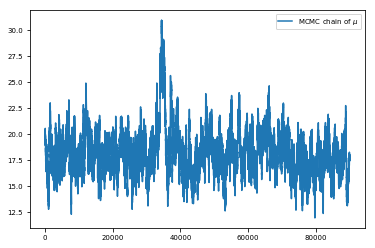

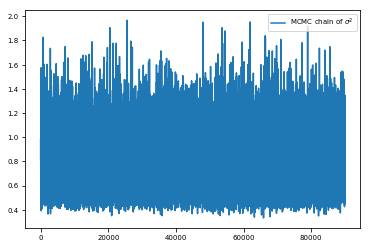

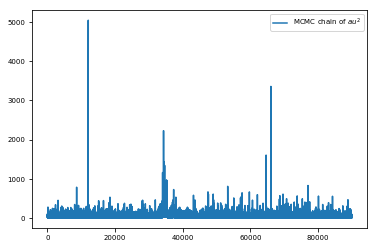

In [34]:
plt.plot(muChain[nBurnin:], label='MCMC chain of $\mu$')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('q8b_mu.png', dpi=720)
plt.show()

plt.plot(sigmaSqChain[nBurnin:], label='MCMC chain of $\sigma^{2}$')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('q8b_sigma.png', dpi=720)
plt.show()

plt.plot(tauSqChain[nBurnin:], label='MCMC chain of $\tau^{2}$')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('q8b_tau.png', dpi=720)
plt.show()

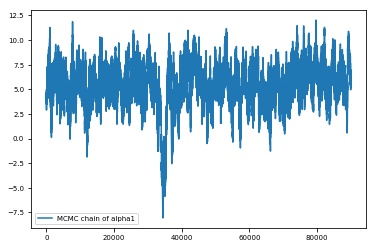

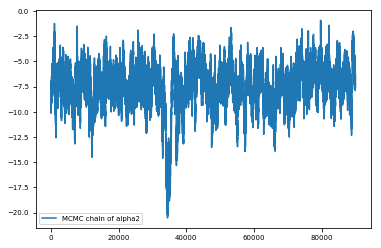

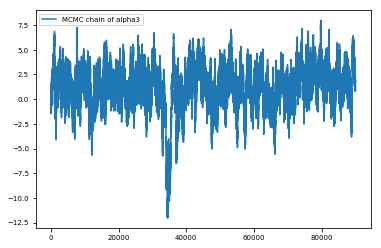

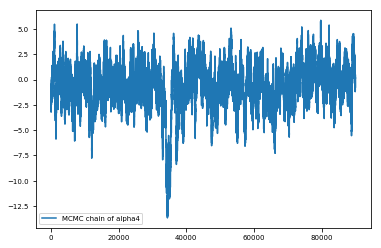

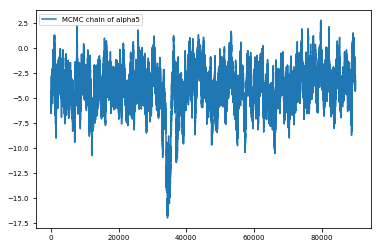

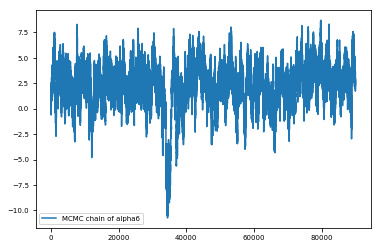

In [35]:
# alpha's
for i in range(I):
    plt.plot(alphaChain[i][nBurnin:], label="MCMC chain of alpha%1d" % (i+1))
    plt.legend(fontsize=7)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.savefig('q8b_alpha_%1d.png' % (i+1), dpi=720)
    plt.show()

In [36]:
print("Mu: mean=%f, variance=%f" % (np.mean(muChain[nBurnin:]), np.var(muChain[nBurnin:])))
print("Sigma^2: mean=%f, variance=%f" % (np.mean(sigmaSqChain[nBurnin:]), np.var(sigmaSqChain[nBurnin:])))
print("Tau^2: mean=%f, variance=%f" % (np.mean(tauSqChain[nBurnin:]), np.var(tauSqChain[nBurnin:])))
for i in range(I):
    print("Alpha_%d: mean=%f, variance=%f" % ((i+1), np.mean(alphaChain[i][nBurnin:]), np.var(alphaChain[i][nBurnin:])))

Mu: mean=18.202018, variance=4.764268
Sigma^2: mean=0.752219, variance=0.029487
Tau^2: mean=32.487927, variance=1825.761497
Alpha_1: mean=5.408351, variance=4.811180
Alpha_2: mean=-7.494034, variance=4.846532
Alpha_3: mean=1.128749, variance=4.823415
Alpha_4: mean=-0.701261, variance=4.830799
Alpha_5: mean=-3.972815, variance=4.834422
Alpha_6: mean=2.198535, variance=4.827453


In [32]:
# Q8c - Use improper prior and check MCMC convergence
nIter = 1000000
nBurnin = 10000

a = 0
b = 0

muChain_c = []
sigmaSqChain_c = []
tauSqChain_c = []
# list of 6 lists
alphaChain_c = [[] for i in range(I)]

# Use random initial values as it's assumed to stabilize afterwards
currMu = np.random.rand()
currAlpha = np.random.rand(I)
currSigmaSq = np.random.rand()
currTauSq = np.random.rand()

# Gibbs sampler update step
for k in range(nIter):
    currMu = updateMu(currAlpha, currSigmaSq)
    currAlpha = updateAlpha(currMu, currSigmaSq, currTauSq)
    currSigmaSq = updateSigmaSq(currMu, currAlpha, a, b)
    currTauSq = updateTauSq(currAlpha, a, b)
    
    muChain_c.append(currMu)
    sigmaSqChain_c.append(currSigmaSq)
    tauSqChain_c.append(currTauSq)
    for i in range(I):
        alphaChain_c[i].append(currAlpha[i])

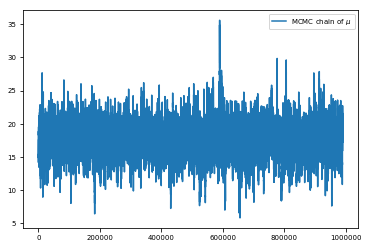

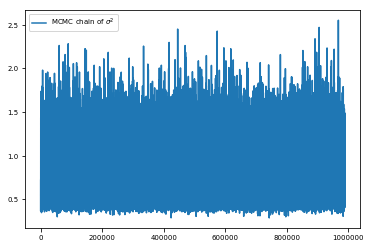

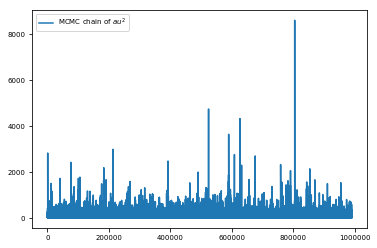

In [40]:
plt.plot(muChain_c[nBurnin:], label='MCMC chain of $\mu$')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('q8c_mu.png')
plt.show()

plt.plot(sigmaSqChain_c[nBurnin:], label='MCMC chain of $\sigma^{2}$')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('q8c_sigma.png')
plt.show()

plt.plot(tauSqChain_c[nBurnin:], label='MCMC chain of $\tau^{2}$')
plt.legend(fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('q8c_tau.png')
plt.show()

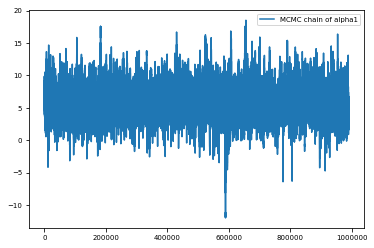

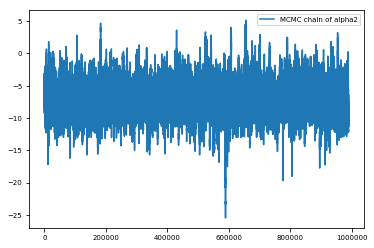

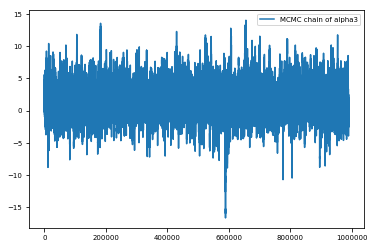

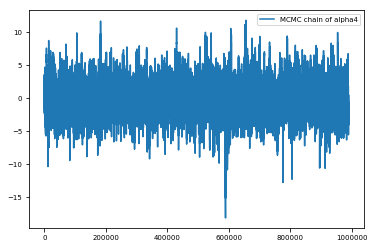

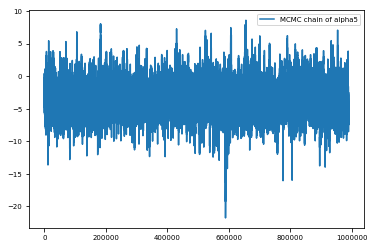

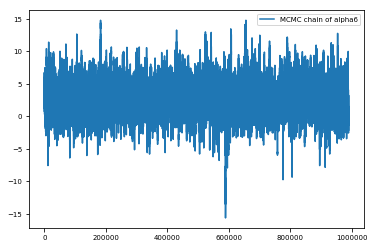

In [41]:
# alpha's
for i in range(I):
    plt.plot(alphaChain_c[i][nBurnin:], label="MCMC chain of alpha%1d" % (i+1))
    plt.legend(fontsize=7)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.savefig('q8c_alpha_%1d.png' % (i+1))
    plt.show()

In [42]:
print("Mu: mean=%f, variance=%f" % (np.mean(muChain_c[nBurnin:]), np.var(muChain_c[nBurnin:])))
print("Sigma^2: mean=%f, variance=%f" % (np.mean(sigmaSqChain_c[nBurnin:]), np.var(sigmaSqChain_c[nBurnin:])))
print("Tau^2: mean=%f, variance=%f" % (np.mean(tauSqChain_c[nBurnin:]), np.var(tauSqChain_c[nBurnin:])))
for i in range(I):
    print("Alpha_%d: mean=%f, variance=%f" % ((i+1), np.mean(alphaChain_c[i][nBurnin:]), np.var(alphaChain_c[i][nBurnin:])))

Mu: mean=17.647353, variance=5.624910
Sigma^2: mean=0.752081, variance=0.029847
Tau^2: mean=34.959907, variance=1821.597112
Alpha_1: mean=5.963759, variance=5.687883
Alpha_2: mean=-6.941734, variance=5.686672
Alpha_3: mean=1.683215, variance=5.686749
Alpha_4: mean=-0.146511, variance=5.686136
Alpha_5: mean=-3.420176, variance=5.690035
Alpha_6: mean=2.752514, variance=5.688275
